# Cellpose whole-cell segmentation using GPU

---

## Introduction

This notebook performs GPU enabled cellpose segmentation on a directory specifed by the user. The notebook has options to save the resulting segmentation as a .npy file for loading into the cellpose gui, .png masks or .txt outlines for ROI import into ImageJ.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/JoeBlackSci/high-plex-whole-cell-segmentation-mp2/cellpose_segmentaion_gpu.ipynb)

This notebook has been adapted from the notebook by Matteo Carandini hosted on the Cellpose github page. 

[LICENSE](https://github.com/MouseLand/cellpose/blob/master/LICENSE)

---
**Notebook Author:** Joseph Blackwell  
School of Life Sciences, University of Warwick, United Kingdom  
Contact: j.blackwell@warwick.ac.uk

## Configuration

If using colab ensure you are connected to a GPU enabled session. 

Go to Runtime -> Change runtime type and set hardware accelerator to GPU.

If you need to upload and save many files it is recommended to mount your google drive for data input and output.

## Installation

In [ ]:
!pip install cellpose

In [2]:
import numpy as np
import time, os, sys
import skimage.io
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
mpl.rcParams['figure.dpi'] = 300

from glob import glob
from tifffile import imread, imwrite

In [3]:
def visimgs(imgs,
            imgnames=None,
            cols=4,
            plotsize=(20, 20),
            save=False,
            savename='tiffcomfig'):
    """Visualise images in a gridbased plot.

    Keyword arguments:
    imgs -- list; images as np arrays
    imgnames -- list; optional names for img titles
    cols -- int; columns for grid arrangement (default=4)
    plotsize -- tuple; size of grid (default=(20,20))
    save -- bool; save an image grid (default=False)
    savename -- string; path used for saving gid

    returns none
    """
    fig = plt.figure(figsize=plotsize)
    rows = -(-len(imgs) // cols)
    for i in range(1, len(imgs) + 1):
        fig.add_subplot(rows, cols, i)
        plt.imshow(imgs[i - 1])
        plt.axis('off')
        if imgnames:
            plt.title(imgnames[i - 1])
    if save:
        plt.savefig(savename+'.png', format='png')
    plt.show()

## Input and Visualisation

In [ ]:
# Input
# directory containing images for segmentation
indir = 'path/to/imgs/'

# glob files
files = sorted(glob(indir + '*.tif'))

In [6]:
# Loading images
imgs = [skimage.io.imread(f) for f in files]
nimg = len(imgs)

print(nimg, 'image(s) loaded')

3 image(s) loaded


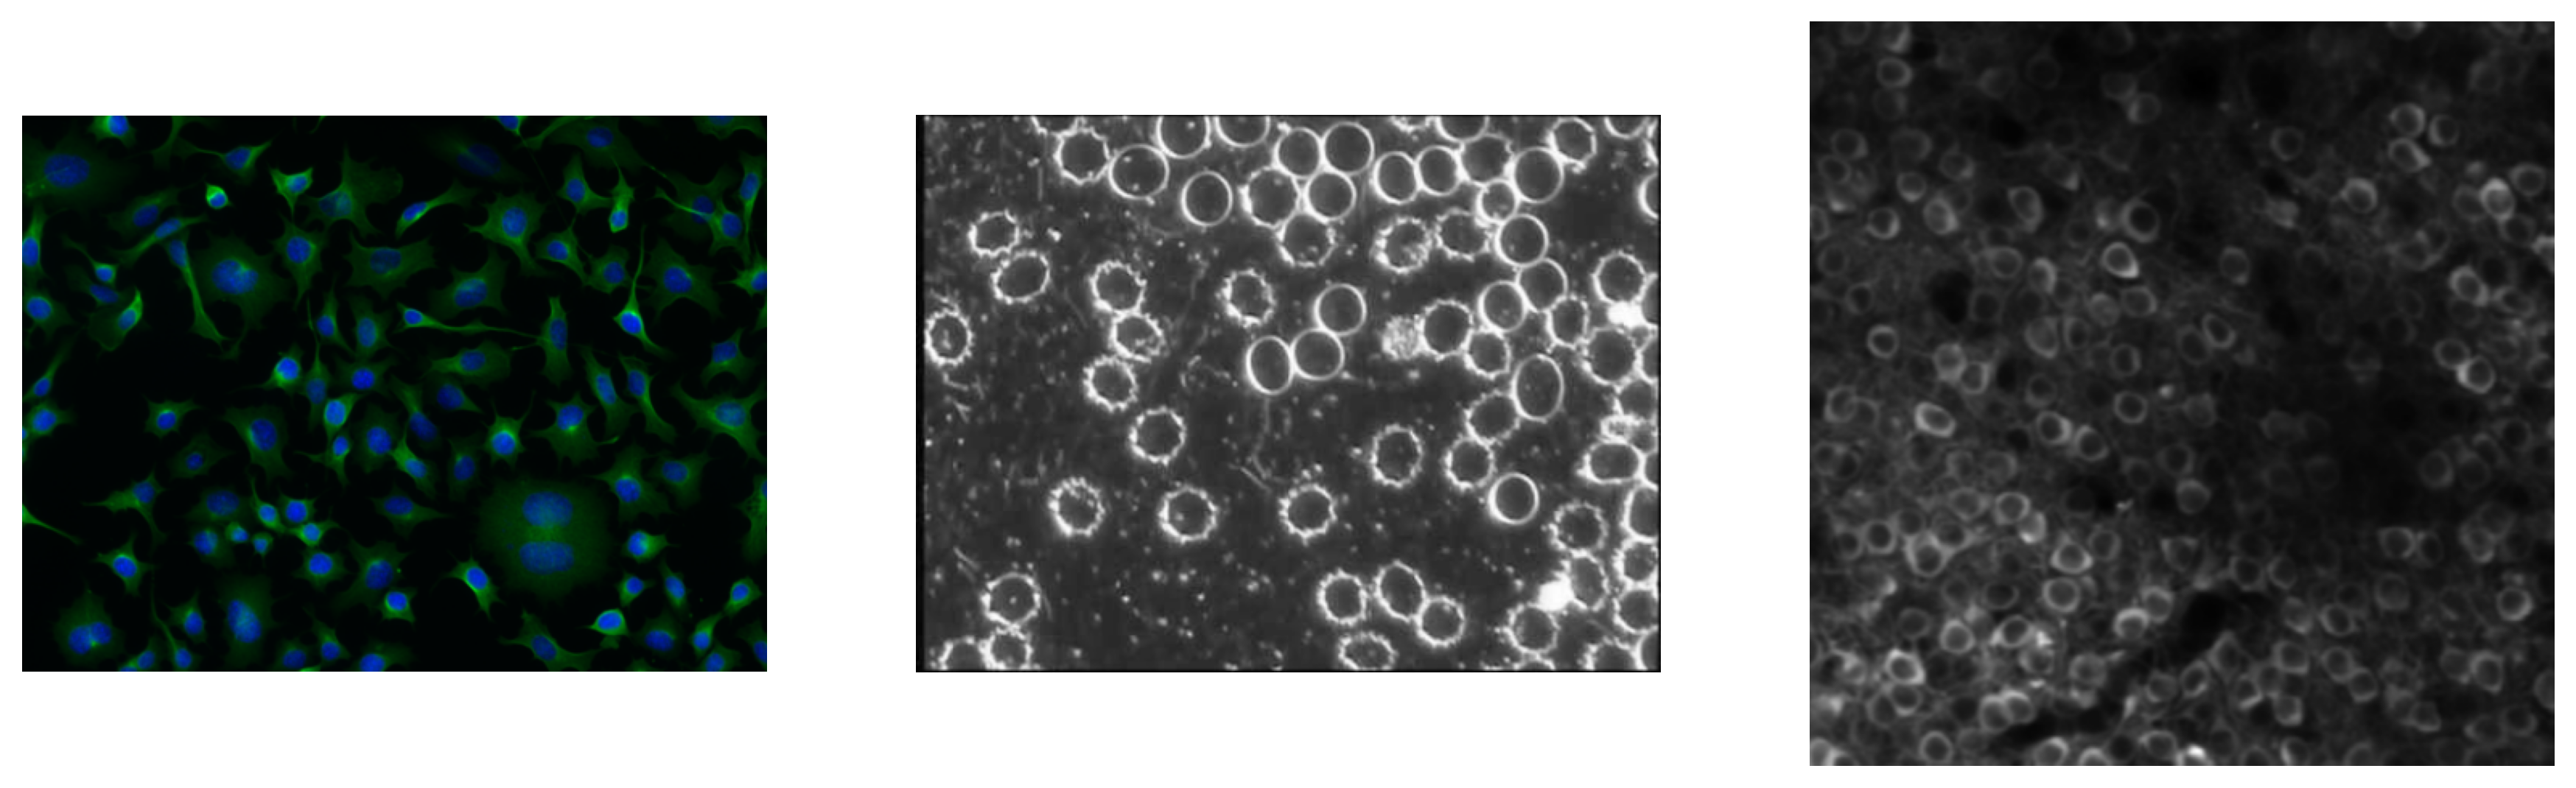

In [7]:
visimgs(imgs)

## Segmentation

In [ ]:
from cellpose import models

use_gpu = models.use_gpu()

# model_type='cyto' or model_type='nuclei'
model = models.Cellpose(gpu=use_gpu, model_type='cyto')

# define CHANNELS to run segementation on
# grayscale=0, R=1, G=2, B=3
# channels = [cytoplasm, nucleus]
# if NUCLEUS channel does not exist, set the second channel to 0
# channels = [0,0]
# IF ALL YOUR IMAGES ARE THE SAME TYPE, you can give a list with 2 elements
# channels = [0,0] # IF YOU HAVE GRAYSCALE
# channels = [2,3] # IF YOU HAVE G=cytoplasm and B=nucleus
# channels = [2,1] # IF YOU HAVE G=cytoplasm and R=nucleus

# or if you have different types of channels in each image

channels = channels = [0,0]

# if diameter is set to None, the size of the cells is estimated on a per image basis
# you can set the average cell `diameter` in pixels yourself (recommended) 
# diameter can be a list or a single number for all images

masks, flows, styles, diams = model.eval(imgs, diameter=None, flow_threshold=None, channels=channels)

## Display results

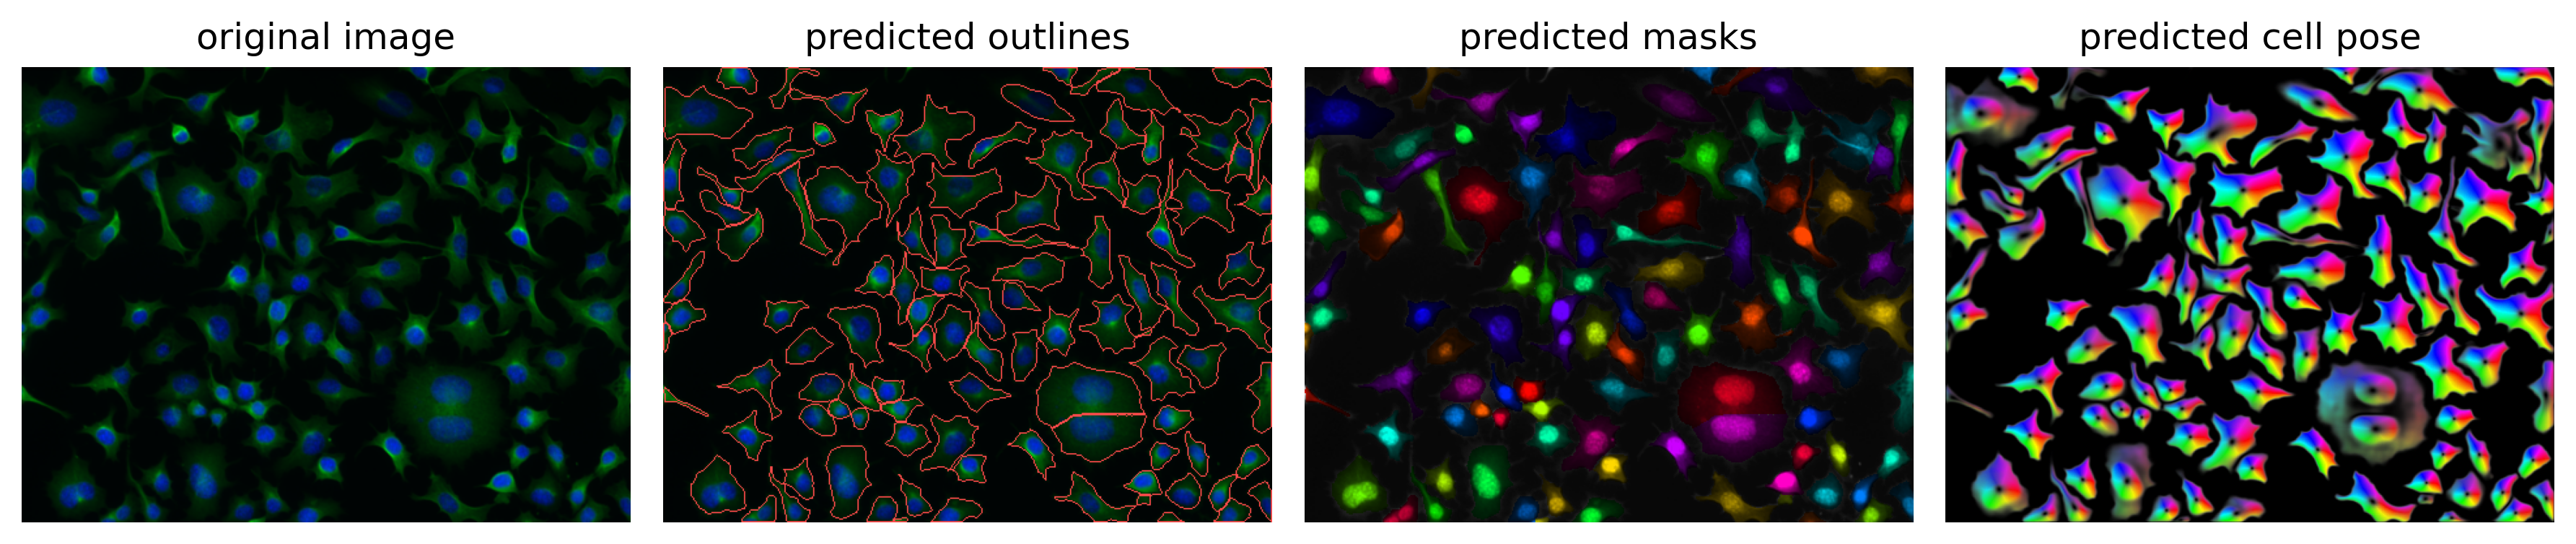

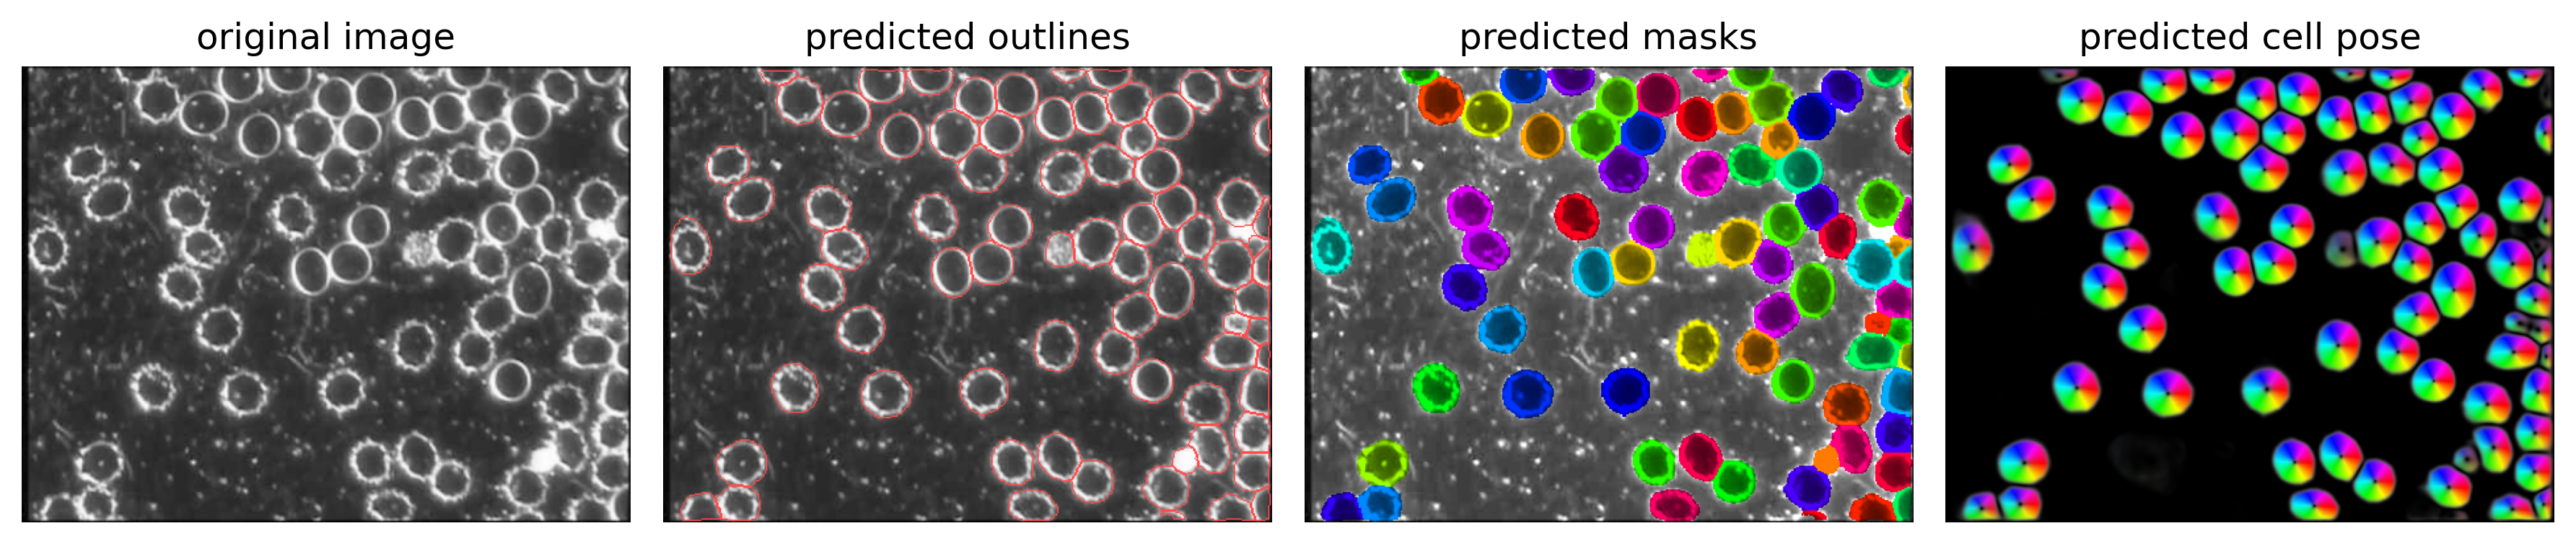

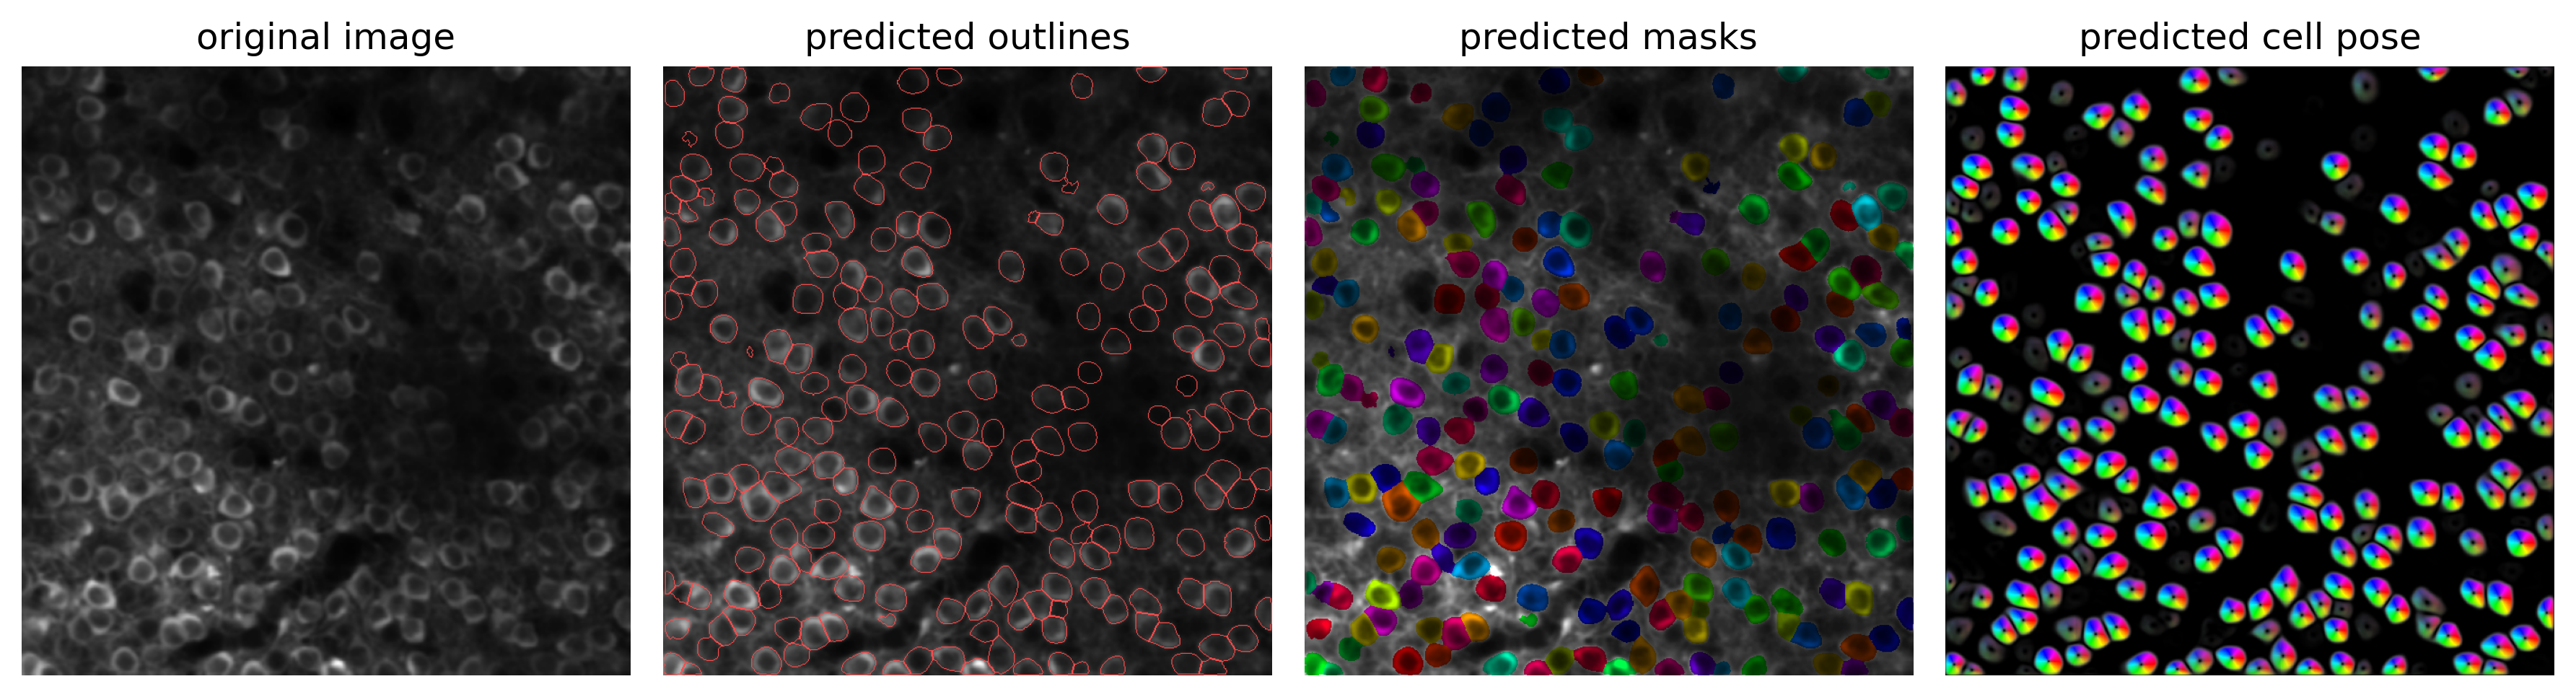

In [9]:
from cellpose import plot

nimg = len(imgs)
for i,img in enumerate(imgs):
    maski = masks[i]
    flowi = flows[i][0]

    fig = plt.figure(figsize=(12,5))
    plot.show_segmentation(fig, img, maski, flowi, channels=channels[0])
    plt.tight_layout()
    plt.show()

## Saving output

In [10]:
# Saving .npy files for complete output
from cellpose import io

io.masks_flows_to_seg(imgs, masks, flows, diams, files, channels)

In [11]:
# Saving .png files for segmentation masks
from cellpose import io

io.save_masks(imgs, masks, flows, files)

In [12]:
# Saving ROI comptible with ImageJ, outputs '_cp_outlines.txt'
from cellpose import io, utils

for i in range(len(imgs)):
    base = os.path.splitext(files[i])[0]
    outlines = utils.outlines_list(masks[i])
    io.outlines_to_text(base, outlines)

# Running the file imagej_roi_converter.py provided in the cellpose repository 
# as a macro from within ImageJ will prompt a path to the '_cp_outlines.txt' 
# file. After input, this will load the outlines to the ROI manager